### 2018/2019 - Task List 5

[Book](https://raw.githubusercontent.com/jonesgithub/book-1/master/ML%20Machine%20Learning-A%20Probabilistic%20Perspective.pdf)


Pyro [SVI](http://pyro.ai/examples/svi_part_i.html#Setup)

Pyro [Bayesian Regression - Introduction](http://pyro.ai/examples/bayesian_regression.html)

[Video introduction to Bayesian Inference](https://www.youtube.com/watch?time_continue=3&v=DYRK0-_K2UU)

0. 
 - Look at sample code
 - Watch introductory video
 - Read pyro introduction to bayesian regression
1. Select pair of parameters from Task List 3 that has bigest corellation
2. Train classic linear regresion
3. Train Bayesian lienar regresion
4. Visualize results in both cases

## Required imports

In [1]:
%matplotlib inline
import pyro
import torch
import numpy as np
import matplotlib.pyplot as plt
import pyro.optim as optim
import pyro.distributions as dist
from torch.distributions import constraints
from tqdm import tqdm
from matplotlib import animation, rc
from IPython.display import HTML
import torch.nn as nn
from functools import partial
import pandas as pd
from pyro.contrib.autoguide import AutoDiagonalNormal
from pyro.infer import EmpiricalMarginal, SVI, Trace_ELBO, TracePredictive

In [2]:
pyro.set_rng_seed(1)
pyro.enable_validation(True)

## Generate some linear data

In [3]:
a=2.0
b=3.0
noise_mean=0
noise_std=10
count=50

In [4]:
base=torch.arange(0, count).type(torch.FloatTensor)
with pyro.plate("noise_plate", count):
    noise=pyro.sample("noise", pyro.distributions.Normal(noise_mean, noise_std))

x=base
y=x*a+b+noise

In [5]:
x

tensor([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12., 13.,
        14., 15., 16., 17., 18., 19., 20., 21., 22., 23., 24., 25., 26., 27.,
        28., 29., 30., 31., 32., 33., 34., 35., 36., 37., 38., 39., 40., 41.,
        42., 43., 44., 45., 46., 47., 48., 49.])

In [6]:
y

tensor([-12.2560,  -2.5023,   0.4602,  -7.0948,   9.9983,   6.9081,   5.2023,
          0.9090,  11.8786,  24.0372,  15.2269,  22.4854,  24.7773,  45.8711,
         33.2843,  37.6764,  28.0303,  25.3924,  45.9954,  42.9908,  51.6569,
         47.4440,  40.3709,  57.0731,  62.0168,  51.2406,  32.5444,  42.5354,
         59.6116,  54.8226,  55.0193,  63.6838,  85.7935,  68.2787,  71.6628,
         68.6296,  82.6260,  81.4151,  90.6514, 101.1539,  85.1518,  79.7581,
         85.1400,  82.5536, 106.3925,  84.3041,  61.6885,  89.5213, 110.1735,
        103.9814])

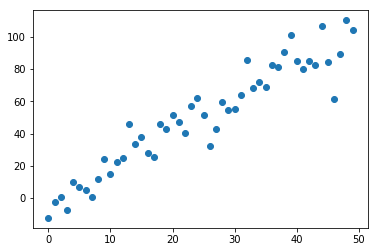

In [7]:
plt.plot(x.numpy(), y.numpy(), "o")

Prepare rows of data

In [8]:
x_data=x[:,None]
y_data=y[:,None]

## Model

\begin{align}
y & = a*x+b
\end{align}

In [9]:
class RegressionModel(nn.Module):
    def __init__(self):
        # p = number of features
        super(RegressionModel, self).__init__()
        self.linear = nn.Linear(1, 1)
        self.factor = nn.Parameter(torch.tensor(1.))

    def forward(self, x):
        return self.linear(x) + (self.factor * x)

## Train linear regression

Learning code

In [10]:
def train_linear_model(x, y):
    model=RegressionModel()
    loss_fn = torch.nn.MSELoss(reduction='sum')
    optim = torch.optim.Adam(model.parameters(), lr=0.0008)
    num_iterations = 2000
    for j in tqdm(range(num_iterations)):
        # run the model forward on the data
        y_pred = model(x)
        # calculate the mse loss
        loss = loss_fn(y_pred, y)
        # initialize gradients to zero
        optim.zero_grad()
        # backpropagate
        loss.backward()
        # take a gradient step
        optim.step()
        if (j + 1) % 5000 == 0:
            print("[iteration %04d] loss: %.4f" % (j + 1, loss.item()))
    # Inspect learned parameters
    print("Learned parameters:")
    for name, param in model.named_parameters():
        print(name, param.data.numpy())
    return model

Train

In [11]:
trained_model = train_linear_model(x_data, y_data)

100%|██████████| 2000/2000 [00:01<00:00, 1827.60it/s]

Learned parameters:
factor 1.53962242603302
linear.weight [[ 0.52025026]]
linear.bias [ 0.59336054]


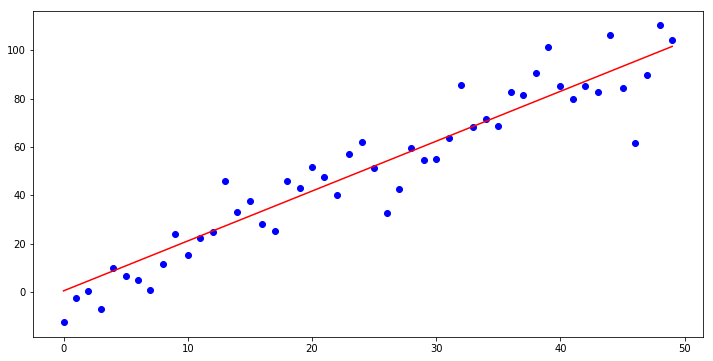

In [12]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12, 6))
plt.plot(x_data.squeeze().numpy(), y_data.squeeze().numpy(), "bo")
y_learned=trained_model.forward(x_data)
plt.plot(x_data.squeeze().numpy(), y_learned.detach().squeeze().numpy(), 'r');

## Bayesian linear regresion

probabilistic model

assume some prior probabilities, get likelihood from data

In [13]:
def create_probabilistic_model():
    regression_model=RegressionModel()
    def probabilistic_model(x_data, y_data):
        # weight and bias priors
        w_prior = pyro.distributions.Normal(torch.ones(1, 1)*3, torch.ones(1, 1)).to_event(1)
        b_prior = pyro.distributions.Normal(torch.zeros(1,1), torch.ones(1,1)).to_event(1)
        f_prior = pyro.distributions.Normal(2., 1000.)
        priors = {'linear.weight': w_prior, 'linear.bias': b_prior, 'factor': f_prior}
        scale = pyro.sample("sigma", pyro.distributions.Uniform(0., 10.))
        # lift module parameters to random variables sampled from the priors
        lifted_module = pyro.random_module("module", regression_model, priors)
        # sample a nn (which also samples w and b)
        lifted_reg_model = lifted_module()
        with pyro.plate("map", len(x_data)):
            # run the nn forward on data
            prediction_mean = lifted_reg_model(x_data).squeeze(-1)
            # condition on the observed data
            obs=pyro.sample("obs",
                        pyro.distributions.Normal(prediction_mean, scale),
                        obs=y_data)
            return prediction_mean
    return probabilistic_model

training code

use SVI and ELBO loss

In [14]:
def train():
    pyro.clear_param_store()
    num_iterations=1000
    model = create_probabilistic_model()
    guide = AutoDiagonalNormal(model)
    optim = pyro.optim.Adam({"lr": 0.01})
    svi = pyro.infer.SVI(model, guide, optim, loss=pyro.infer.Trace_ELBO(), num_samples=count)
    t=tqdm(range(num_iterations))
    for j in t:
        loss = svi.step(x_data, y_data.squeeze(-1))
        t.set_postfix(loss=loss)
    return (model, svi)

In [15]:
probabilistic_model, svi = train()

100%|██████████| 1000/1000 [00:12<00:00, 79.80it/s, loss=220]   


lets look what parameters we have

In [16]:
for name, value in pyro.get_param_store().items():
    print(name, pyro.param(name))

auto_loc tensor([0.7602, 0.9844, 0.9870, 0.9135], requires_grad=True)
auto_scale tensor([0.7065, 0.3909, 0.3160, 1.0577], grad_fn=<AddBackward0>)


evaluation

use Delta distribution in order to force pyro to sample prediction so we will be able to get parameters of learned distribution

In [17]:
def get_marginal(traces, sites):
    empirical_marginal=EmpiricalMarginal(traces, sites)
    return empirical_marginal._get_samples_and_weights()[0].detach().cpu().numpy()

def summary(traces, sites):
    marginal = get_marginal(traces, sites)
    site_stats = {}
    for i in range(marginal.shape[1]):
        site_name = sites[i]
        site_marginal=marginal[:, i]
        marginal_site = pd.DataFrame(site_marginal).transpose()
        describe = partial(pd.Series.describe, percentiles=[.05, 0.25, 0.5, 0.75, 0.95])
        site_stats[site_name] = marginal_site.apply(describe, axis=1) \
            [["mean", "std", "5%", "25%", "50%", "75%", "95%"]]
    return site_stats

def wrapped_model(x_data, y_data):
    model_result=probabilistic_model(x_data, y_data)
    pyro.sample("prediction", pyro.distributions.Delta(model_result))

posterior = svi.run(x_data, y_data)

In [18]:
trace_pred = TracePredictive(wrapped_model,
                             posterior,
                             num_samples=count)
post_pred = trace_pred.run(x_data, None)
post_summary = summary(post_pred, sites= ['prediction', 'obs'])
mu = post_summary["prediction"]
y = post_summary["obs"]
predictions = pd.DataFrame({
    "x": x_data,
    "mu_mean": mu["mean"],
    "mu_perc_5": mu["5%"],
    "mu_perc_95": mu["95%"],
    "y_mean": y["mean"],
    "y_perc_5": y["5%"],
    "y_perc_95": y["95%"],
    "true_y": y_data,
})

Plot probabilities

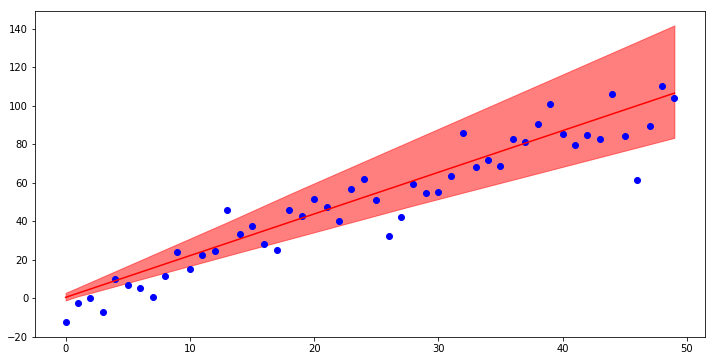

In [19]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12, 6))
x_values=x_data.squeeze().numpy()
plt.plot(x_values, y_data.squeeze().numpy(), "bo")
plt.plot(x_values, predictions['mu_mean'], 'r');
plt.fill_between(x_values,
                   predictions["mu_perc_5"],
                   predictions["mu_perc_95"],
                   color='r',
                   alpha=0.5);

Plot outcome variables

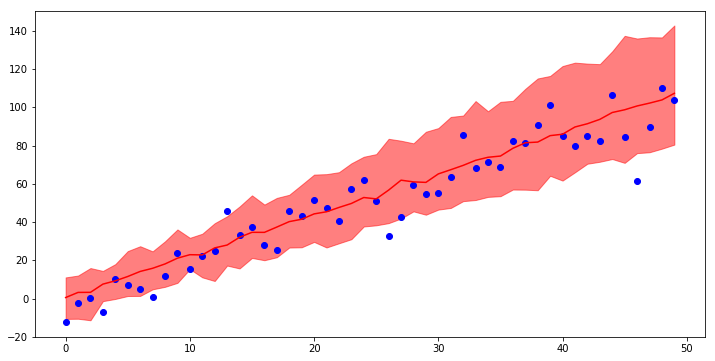

In [20]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12, 6))
x_values=x_data.squeeze().numpy()
plt.plot(x_values, y_data.squeeze().numpy(), "bo")
plt.plot(x_values, predictions['y_mean'], 'r');
plt.fill_between(x_values,
                   predictions["y_perc_5"],
                   predictions["y_perc_95"],
                   color='r',
                   alpha=0.5);

# Solutions

In [22]:
## Insert solution here